# Laporan Kelompok 7 - Car Recognition

dataset : [Dataset](https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder)

*   Aditya Raybol Saragih
*   Yanuar
*   Lutfi Rizky Ramadhan



In [4]:
#Melakukan import library yang dibutuhkan

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import PIL.Image as Image
from IPython.display import display

#cek apakah runtime yang sedang digunakan support cuda/tidak
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla K80


## 1 - Akses Data

In [5]:
#Akses data menggunakan file/folder yang sudah diupload ke google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#base folder/tempat data diupload
dataset_dir = "/content/drive/My Drive/car_data/"

## 2 - Mengolah Data

In [0]:
#membuat transformasi data train menjadi 400x400, dengan random horizontal flip, random rotataion sebanyak 15 derajat, konversi ke dalam bentuk tensor
#dan normalisasi data tersebut
train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#membuat transformasi data test menjadi 400x400, konversi ke dalam tensor, serta normalisasi data tersebut
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#Load gambar/data training ke dalam variable, memakai transformasi yang sudah dibuat di atas
#dengan batch size sebanyak 32 sample per batch setiap kali load
#shuffle = true, akan membuat pada setiap epoch yang dijalankan model nantinya akan dilakukan shuffling data 
#num_workers = 2, menggunakan 2 worker untuk proses input data train
dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

#Load gambar/data test ke dalam variable, memakai transformasi yang sudah dibuat di atas
#dengan batch size sebanyak 32 sample per batch setiap kali load
#shuffle = false, akan membuat pada setiap epoch yang dijalankan model nantinya TIDAK dilakukan shuffling data 
#num_workers = 2, menggunakan 2 worker untuk proses input data 
dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)

## 3 - Model Development

In [0]:
#membuat fungsi train dengan parameter
#model, criterion, optimizer, scheduler, n_epochs
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = [] #untuk mengukur banyaknya losses pada setiap epoch
    accuracies = [] #untuk mengukur akurasi pada setiap epoch
    test_accuracies = [] #untuk mengukur akurasi pada test data pada setiap epoch
    # set model untuk mode training
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # mengambil inputan dan memasukkannya ke dalam cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            #kalkulasi loss/acc 
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        #print output setiap selesai epoch
        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        #memasukan loss dan akurasi
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # ganti mode model ke dalam mode evaluasi untuk mengevaluasi data tes
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # set model kembali ke mode train setelah proses evaluasi/validasi di atas
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies #return model, hasil loss, hasil akurasi, dan akurasi test

In [0]:
#membuat fungsi evaluasi model untuk mengukur test akurasi
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [10]:
#menggunakan resnet34 untuk pre-train model
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

#criterion menggunakan Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
#Optimizer menggunakan SGD
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
#Scheduler digunakan untuk tracking akurasi pada training setiap epoch selesai, jika tidak naik setidaknya 0.9, turunkan nilai lr sebanyak 0.1
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 68611963.74it/s]


In [11]:
#Training model menggunakan fungsi yang sudah dibuat serta parameter yang sudah dibuat
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

Epoch 1, duration: 1781 s, loss: 3.9680, acc: 15.9069
Accuracy of the network on the test images: 25 %
Epoch 2, duration: 294 s, loss: 1.6501, acc: 56.6054
Accuracy of the network on the test images: 66 %
Epoch 3, duration: 295 s, loss: 0.8336, acc: 77.5490
Accuracy of the network on the test images: 64 %
Epoch 4, duration: 295 s, loss: 0.5331, acc: 85.0123
Accuracy of the network on the test images: 65 %
Epoch 5, duration: 295 s, loss: 0.3467, acc: 90.5270
Accuracy of the network on the test images: 77 %
Epoch 6, duration: 295 s, loss: 0.2509, acc: 92.9289
Accuracy of the network on the test images: 81 %
Epoch 7, duration: 295 s, loss: 0.1108, acc: 97.6471
Accuracy of the network on the test images: 89 %
Epoch 8, duration: 294 s, loss: 0.0746, acc: 98.3946
Accuracy of the network on the test images: 90 %
Epoch 9, duration: 294 s, loss: 0.0628, acc: 98.7010
Accuracy of the network on the test images: 90 %
Epoch 10, duration: 294 s, loss: 0.0581, acc: 98.7500
Accuracy of the network on 

## 4 - Evaluasi

Text(0.5, 1.0, 'Test acc')

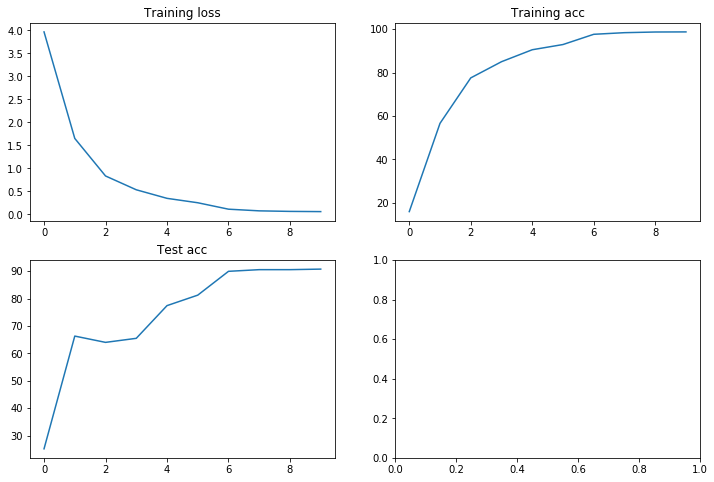

In [13]:
# plotting untuk data training loss, akurasi, dan akurasi pada data test

f, axs = plt.subplots(2,2, figsize = (12, 8))
axs[0, 0].plot(training_losses)
axs[0, 0].set_title("Training loss")
axs[0, 1].plot(training_accs)
axs[0, 1].set_title("Training acc")
axs[1, 0].plot(test_accs)

axs[1, 0].set_title("Test acc")

In [0]:
# mencari nama kelas yang telah diprediksi
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [0]:
# mengubah model menjadi mode evaluasi
model_ft.eval()

# transform gambar input
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#input gambar yang ingin ditest
imgDir = dataset_dir+"test/BMW M3 Coupe 2012/00103.jpg"
image = Image.open(imgDir)
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

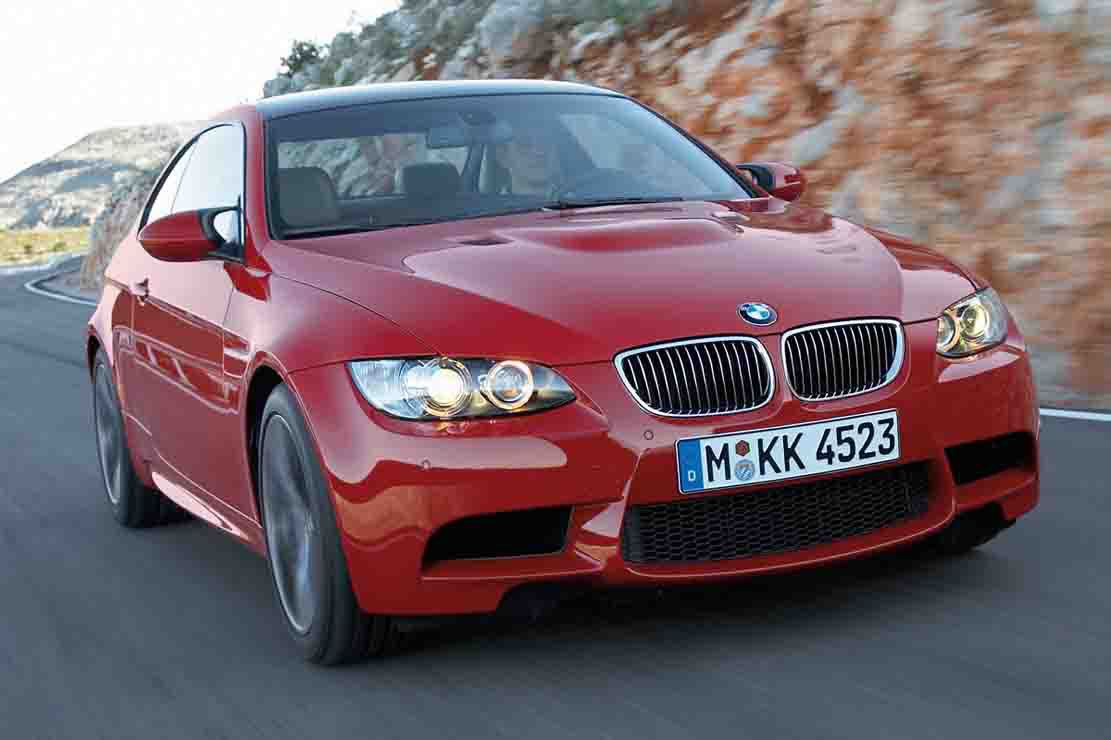

BMW M3 Coupe 2012 confidence:  15.775962829589844


In [24]:
# keluarkan hasil prediksi
display(Image.open(imgDir))
print(classes[predicted.item()], "confidence: ", conf.item())

## 5 - Referensi

https://www.kaggle.com/deepbear/pytorch-car-classifier-90-accuracy

 3D Object Representations for Fine-Grained Categorization
       Jonathan Krause, Michael Stark, Jia Deng, Li Fei-Fei
       4th IEEE Workshop on 3D Representation and Recognition, at ICCV 2013 (3dRR-13). Sydney, Australia. Dec. 8, 2013.
       [pdf](https://ai.stanford.edu/~jkrause/papers/3drr13.pdf)   [BibTex](https://ai.stanford.edu/~jkrause/papers/3drr13.bib)   [slides](https://ai.stanford.edu/~jkrause/papers/3drr_talk.pdf)